In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn import preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [87]:
# Reading the Airbnb-file into a dataframe
df = pd.read_csv('NYlistings.csv.gz')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51361 entries, 0 to 51360
Columns: 106 entries, id to reviews_per_month
dtypes: float64(22), int64(21), object(63)
memory usage: 41.5+ MB


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [88]:
df.columns.values.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


In [89]:
cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating',
        'review_scores_location',
        'review_scores_value'
        ]
LISTINGSFILE = 'NYlistings.csv.gz'
# read the file into a dataframe
df = pd.read_csv(LISTINGSFILE, usecols=cols, compression='infer')

len(df.index)

51361

<AxesSubplot:>

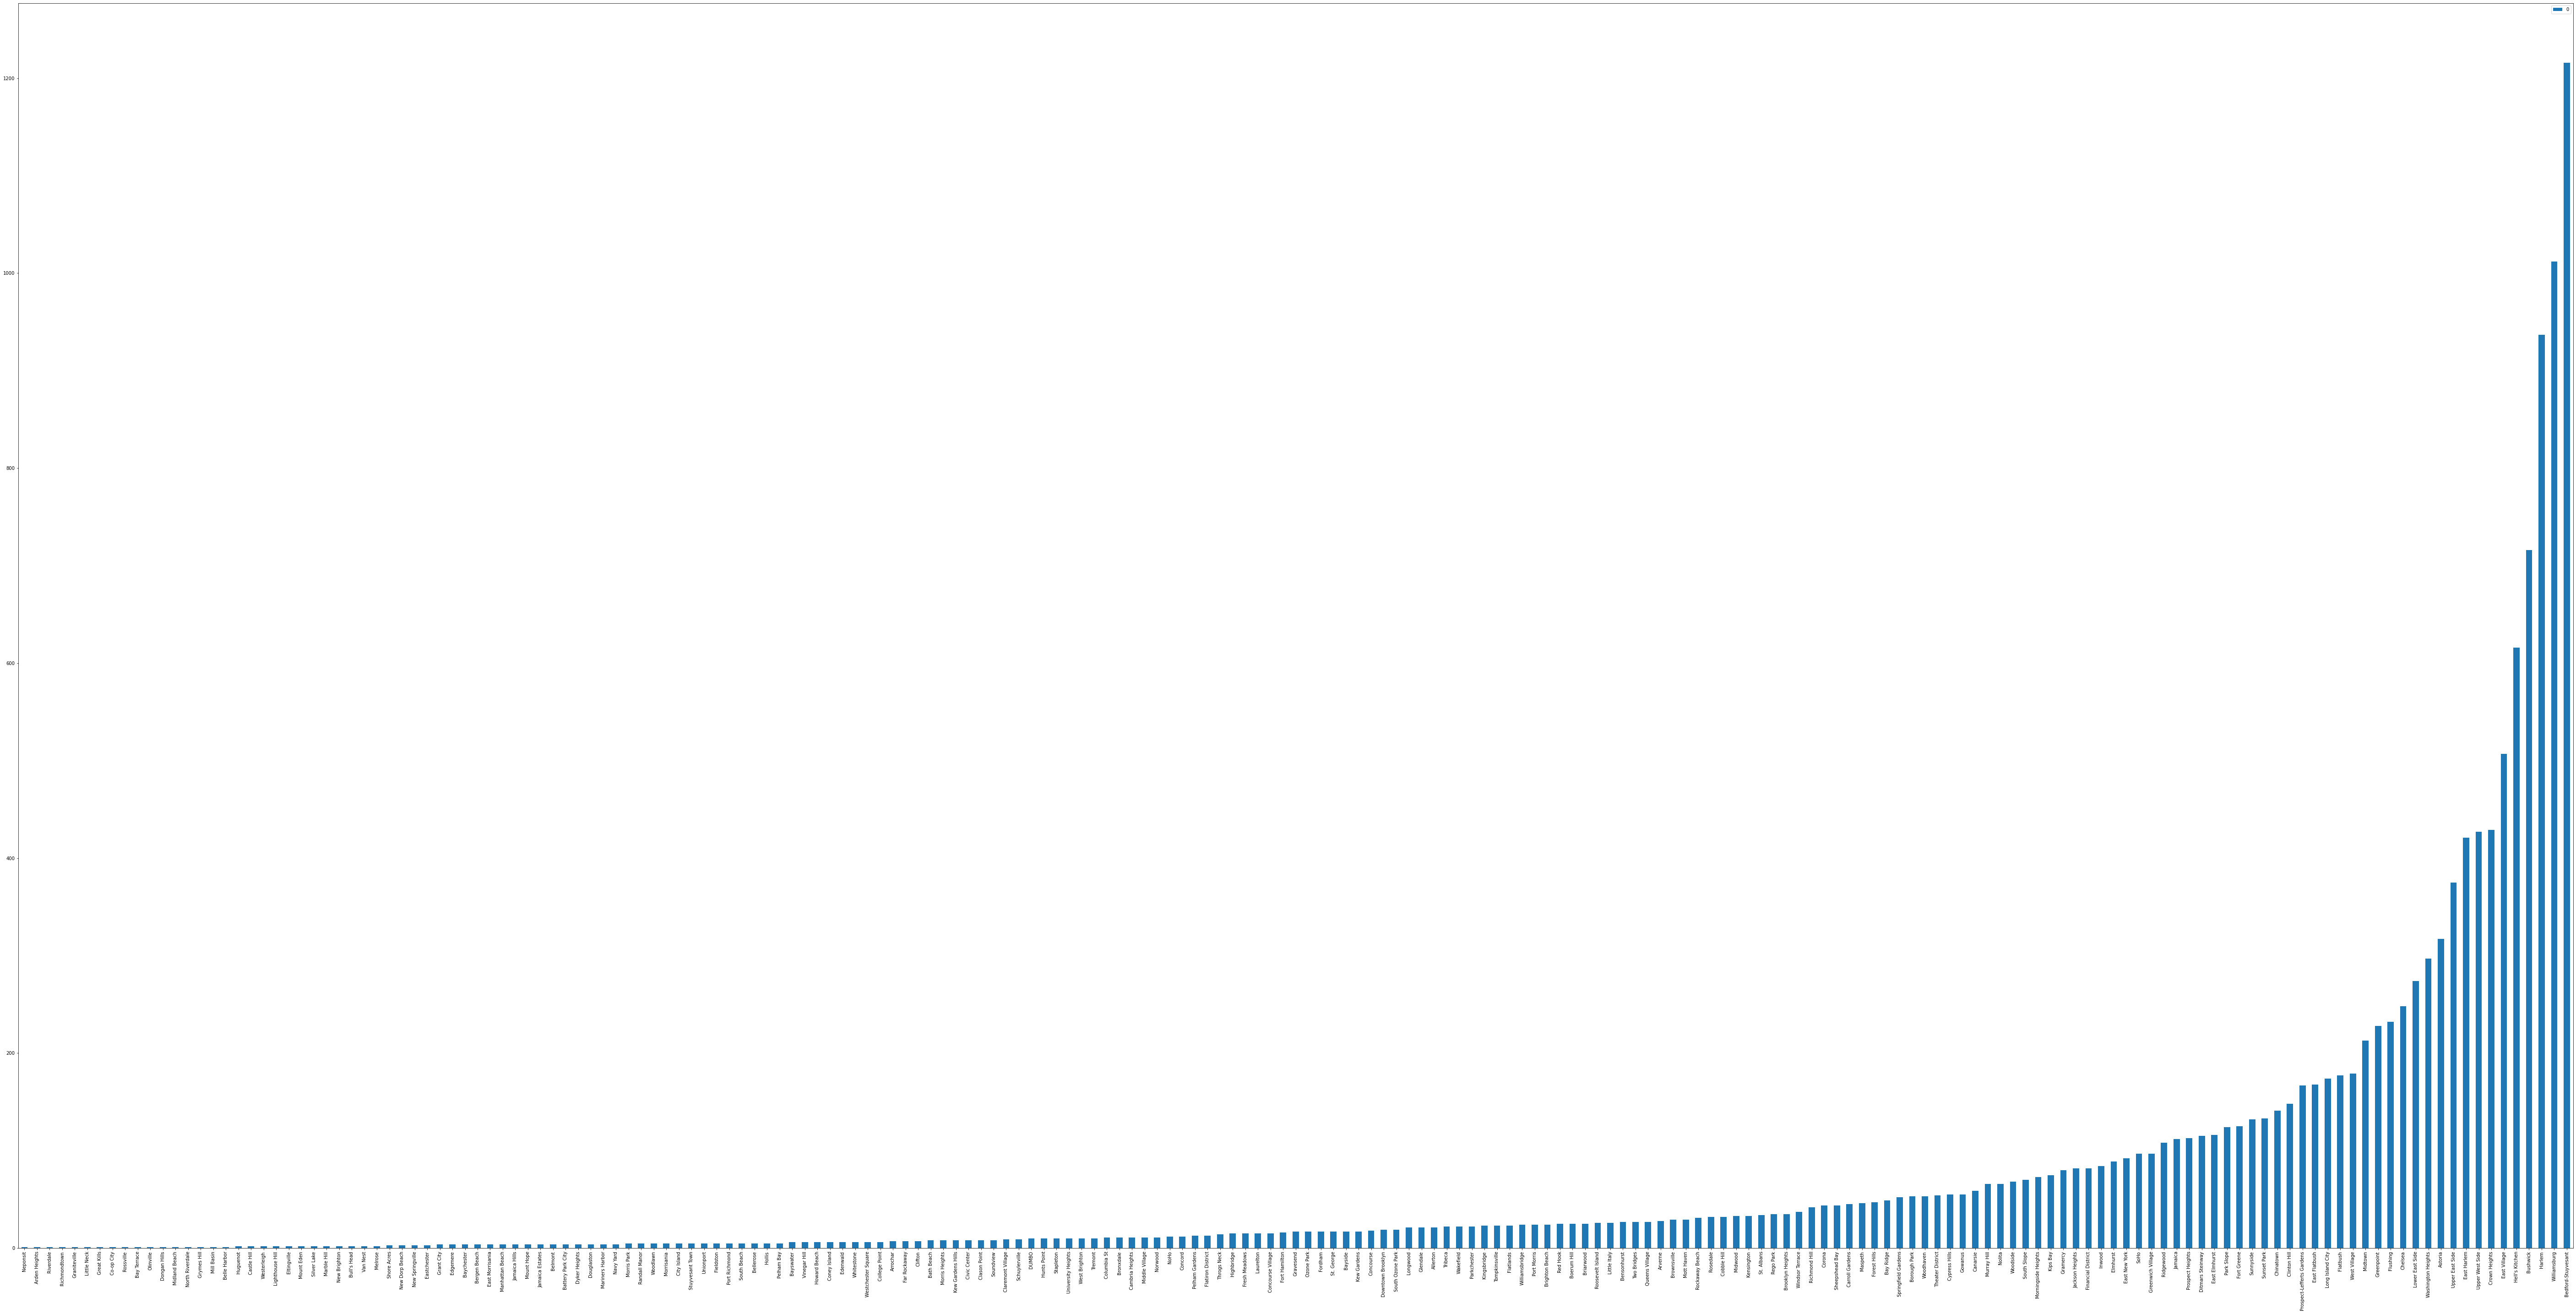

In [109]:
nb_counts = Counter(df.neighbourhood_cleansed)

tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)

tdf.plot(kind='bar', figsize=(100,50))


In [91]:
df.isnull().any()

neighbourhood_cleansed    False
room_type                 False
accommodates              False
bedrooms                   True
beds                       True
price                     False
availability_30           False
number_of_reviews         False
review_scores_rating       True
review_scores_location     True
review_scores_value        True
instant_bookable          False
cancellation_policy       False
dtype: bool

In [92]:
df = df[df.bedrooms == 1]
df = df[df.beds != 0]
df = df[df.review_scores_rating != 0]
df = df[df.review_scores_location != 0]
df = df[df.review_scores_value != 0]
df = df[df.number_of_reviews > 10]
df = df.dropna(axis=0)

len(df.index)

14108

In [93]:
df.price.head()

1     $89.00
2    $200.00
3     $60.00
4     $79.00
5     $79.00
Name: price, dtype: object

In [95]:

df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df.price.head(5)

1     89.0
2    200.0
3     60.0
4     79.0
5     79.0
Name: price, dtype: float64

In [96]:
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns
alldata.head(5)

,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,review_scores_location,review_scores_value,Allerton,...,Entire home/apt,Hotel room,Private room,Shared room,flexible,moderate,strict,strict_14_with_grace_period,super_strict_60,instant_t
1,3,1.0,4.0,89.0,9,298,90.0,10.0,9.0,0,...,1,0,0,0,0,1,0,0,0,0
2,2,1.0,1.0,200.0,0,78,90.0,10.0,9.0,0,...,1,0,0,0,0,1,0,0,0,0
3,2,1.0,1.0,60.0,0,50,90.0,9.0,9.0,0,...,0,0,1,0,0,0,0,1,0,0
4,2,1.0,1.0,79.0,5,459,83.0,10.0,8.0,0,...,0,0,1,0,0,0,0,1,0,0
5,1,1.0,1.0,79.0,0,118,98.0,10.0,10.0,0,...,0,0,1,0,1,0,0,0,0,0


<AxesSubplot:xlabel='neighbourhood_cleansed'>

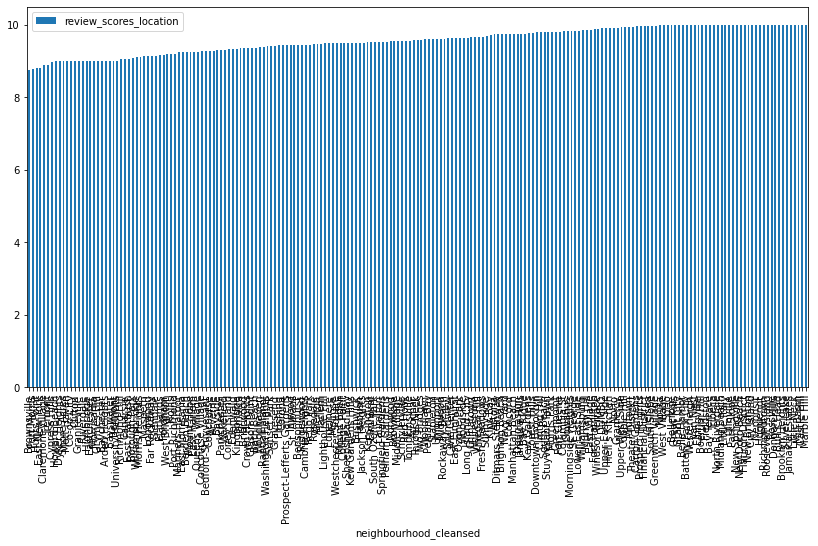

In [118]:
# Let's see the average location scores
nb = Counter(df['neighbourhood_cleansed'])
numbers = list(zp.keys())
nb_rew = df[['neighbourhood_cleansed', 'review_scores_location']]
nb_rew.columns = ['neighbourhood_cleansed', 'review_scores_location']
re = nb_rew.groupby('neighbourhood_cleansed')
nb_rew = re['review_scores_location'].agg(np.mean)
nb_rew = nb_rew.reset_index()
nb_rew['number_of_listings'] = nb.values()
p = nb_rew.sort_values(by = 'review_scores_location')
p.plot(x = 'neighbourhood_cleansed', y = 'review_scores_location', kind = 'bar', figsize = (14,7) )

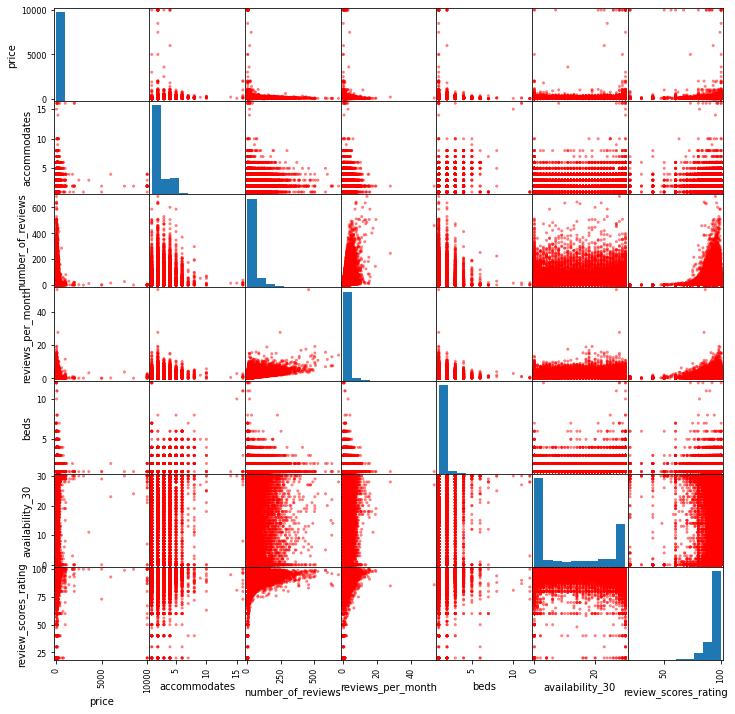

In [14]:
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 'review_scores_rating']
axs = pd.plotting.scatter_matrix(alldata[scattercols],
                        figsize=(12, 12), c='red')

Text(0, 0.5, 'Median Absolute Error')

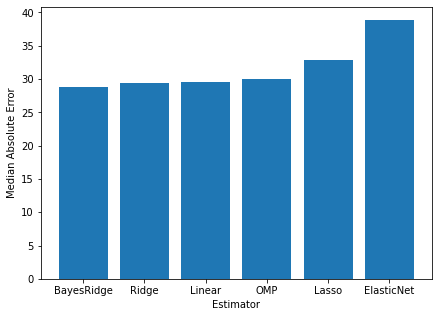

In [16]:
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [18]:
n_est = 300

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 2 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

GradientBoostingRegressor(learning_rate=0.01, loss='lad', max_depth=4,
                          n_estimators=300)

In [19]:
abs(clf.best_score_)

20.383034147396852

Text(0, 0.5, 'Least Absolute Deviation')

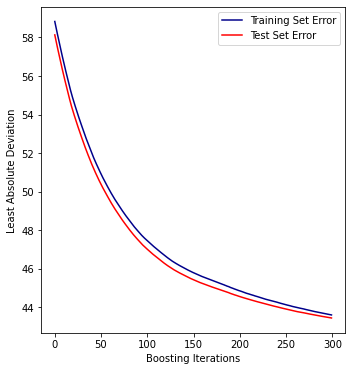

In [20]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

Text(0.5, 1.0, 'Variable Importance')

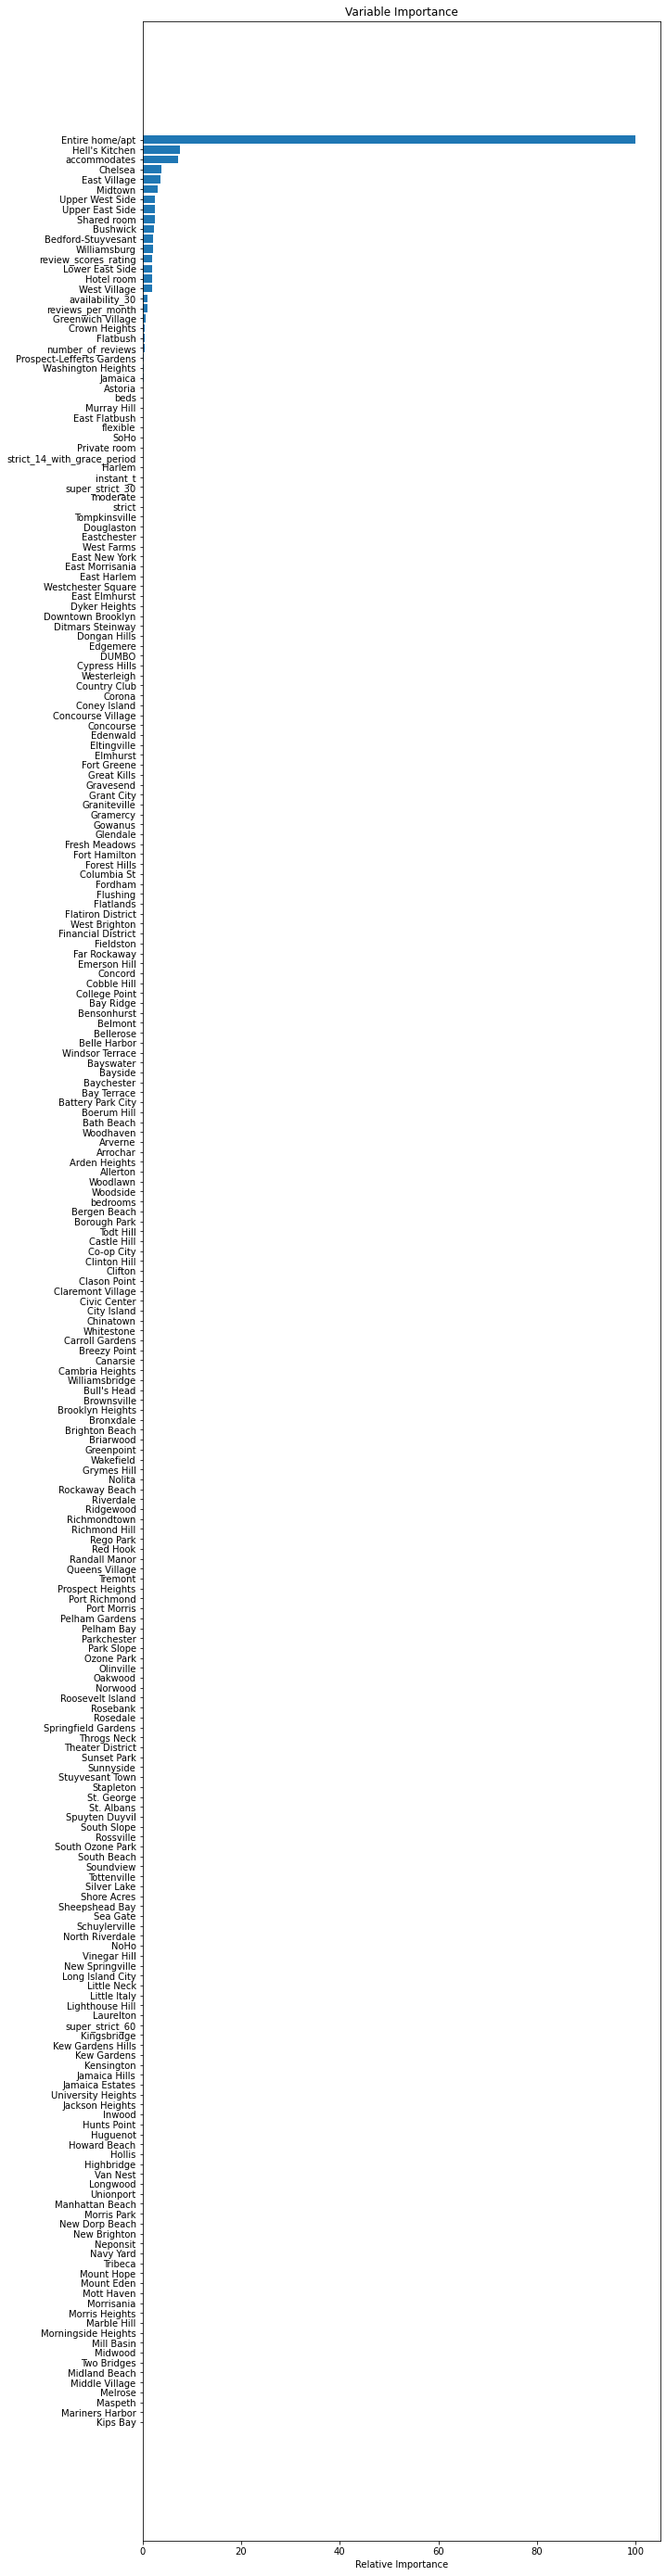

In [24]:
feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(10,50))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')